In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Loading the Data

In [2]:
#training data
from google.colab import files
uploaded = files.upload()

Saving TRAINING_DATA.txt to TRAINING_DATA (3).txt


In [3]:
traindf = pd.read_csv('TRAINING_DATA.txt', delimiter = ",")
traindf.head()

,so2,car.count,wind.velocity,wind.direction,time.of.day,day.index,temperature.1,temperature.30
0,169.099957,1430.000396,1.3,114,21,50,-1.7,-0.3
1,51.000223,2328.990055,2.5,83,20,98,-5.4,-4.0
2,20.299982,2884.999484,2.2,44,18,189,9.8,9.8
3,68.799742,3542.011269,5.9,214,16,108,4.2,4.5
4,82.000062,2531.000606,0.5,296,15,184,8.9,8.3


In [4]:
#testing data
from google.colab import files
uploaded = files.upload()

Saving TESTING_DATA.txt to TESTING_DATA (3).txt


In [5]:
testdf = pd.read_csv('TESTING_DATA.txt', delimiter = ",")
testdf.head()

,car.count,wind.velocity,wind.direction,time.of.day,day.index,temperature.1,temperature.30
0,129.999421,3.0,217,2,177,2.1,2.7
1,2447.004739,5.7,81,18,122,-4.6,-4.8
2,1185.002307,4.9,229,11,126,4.9,4.8
3,3636.001981,3.4,186,16,148,2.4,2.8
4,958.998969,6.9,50,10,90,-6.8,-6.9


## Dataset Explanatory Analysis

In [6]:
traindf.describe()

,so2,car.count,wind.velocity,wind.direction,time.of.day,day.index,temperature.1,temperature.30
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,52.541657,1742.392728,2.836333,142.070000,12.290000,118.096667,0.174333,0.435667
std,35.328505,1160.394920,1.678144,81.896573,6.982963,51.741517,5.719179,5.555367
min,3.900013,81.000068,0.300000,3.000000,1.000000,32.000000,-18.600000,-17.800000
25%,25.299889,686.001627,1.600000,79.000000,7.000000,76.000000,-3.900000,-3.900000
50%,46.700001,1857.992459,2.600000,90.000000,12.500000,113.500000,0.500000,1.200000
75%,70.974927,2449.012106,3.500000,216.750000,18.000000,162.000000,4.500000,4.825000
max,265.700571,4224.009186,9.900000,359.000000,24.000000,212.000000,12.200000,11.500000


In [7]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   so2             300 non-null    float64
 1   car.count       300 non-null    float64
 2   wind.velocity   300 non-null    float64
 3   wind.direction  300 non-null    int64  
 4   time.of.day     300 non-null    int64  
 5   day.index       300 non-null    int64  
 6   temperature.1   300 non-null    float64
 7   temperature.30  300 non-null    float64
dtypes: float64(5), int64(3)
memory usage: 18.9 KB


In [8]:
#check for null values
traindf.isna().sum()

so2               0
car.count         0
wind.velocity     0
wind.direction    0
time.of.day       0
day.index         0
temperature.1     0
temperature.30    0
dtype: int64

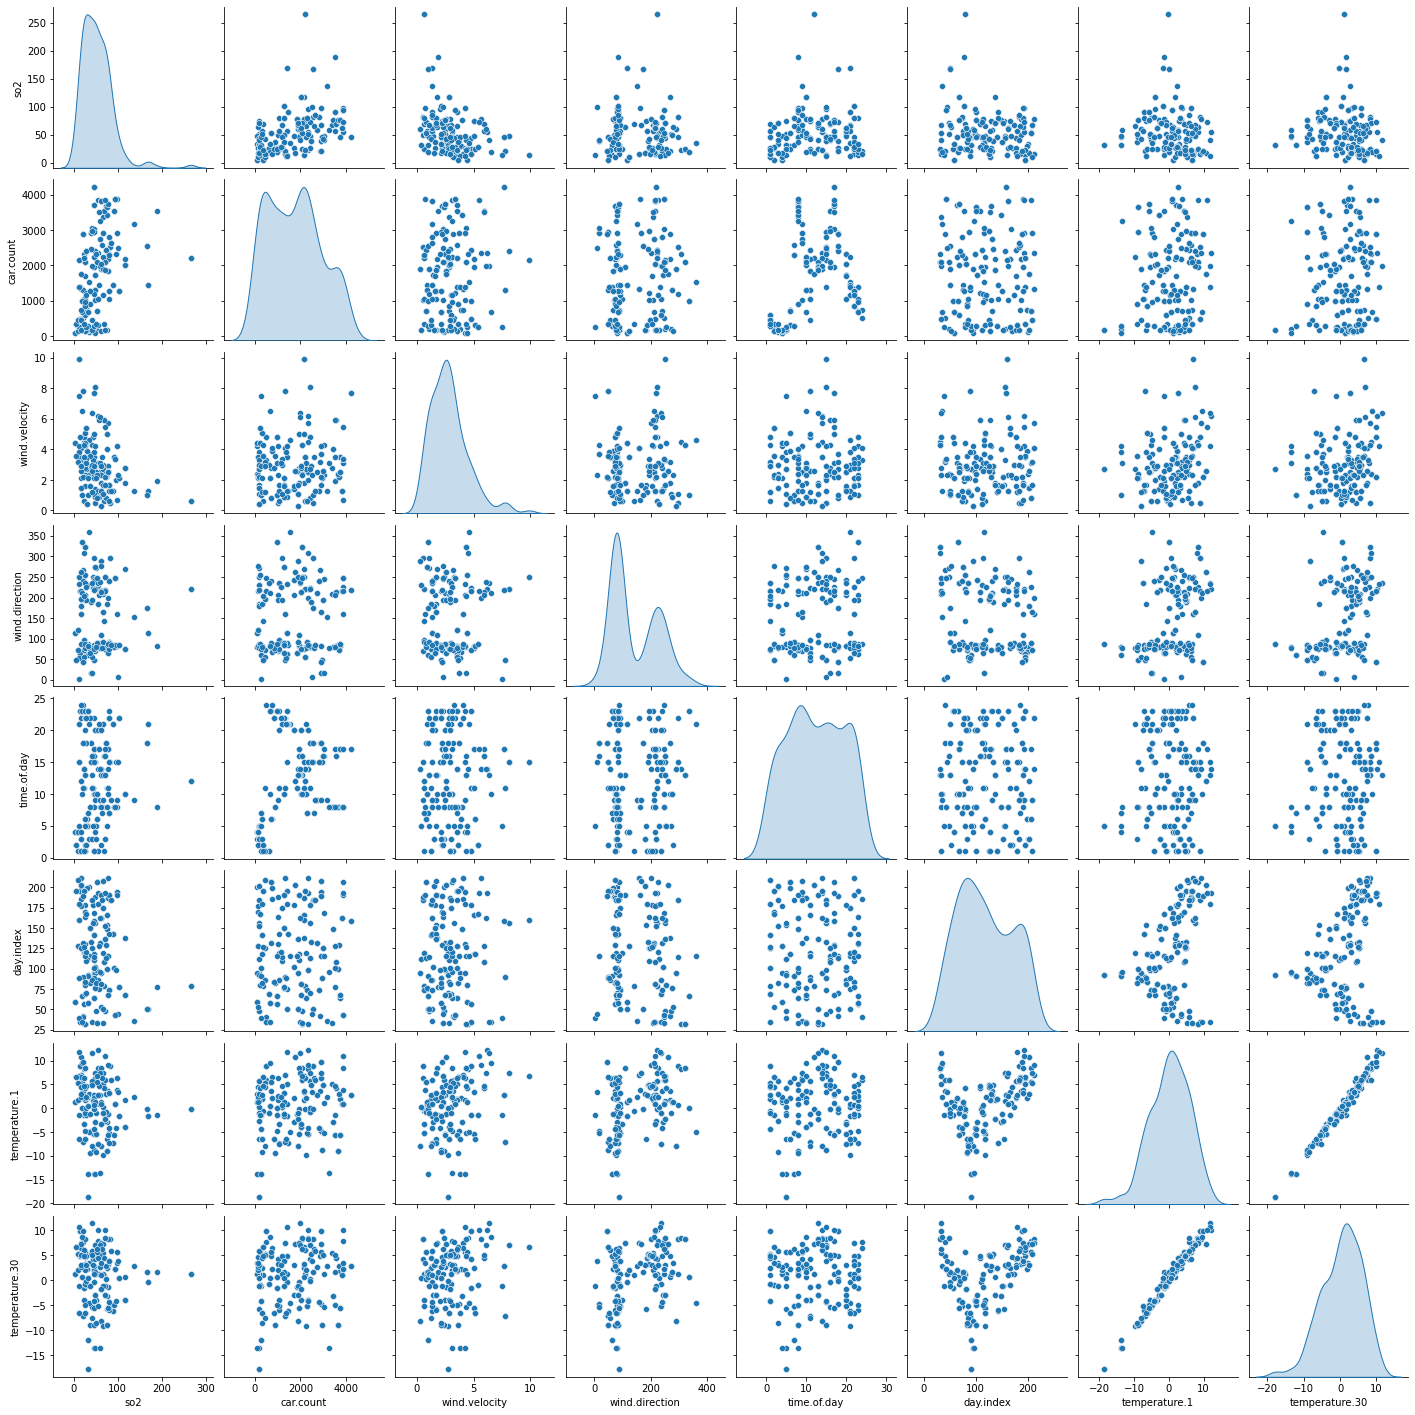

In [9]:
#Plot pairwise relationships. Indicates which variables are related to which.
#so2 appears to be a function of the other variables
sns.pairplot(traindf, diag_kind='kde')


In [10]:
#summary statistics
traindf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
so2,300.0,52.541657,35.328505,3.900013,25.299889,46.700001,70.974927,265.700571
car.count,300.0,1742.392728,1160.394920,81.000068,686.001627,1857.992459,2449.012106,4224.009186
wind.velocity,300.0,2.836333,1.678144,0.300000,1.600000,2.600000,3.500000,9.900000
wind.direction,300.0,142.070000,81.896573,3.000000,79.000000,90.000000,216.750000,359.000000
time.of.day,300.0,12.290000,6.982963,1.000000,7.000000,12.500000,18.000000,24.000000
day.index,300.0,118.096667,51.741517,32.000000,76.000000,113.500000,162.000000,212.000000
temperature.1,300.0,0.174333,5.719179,-18.600000,-3.900000,0.500000,4.500000,12.200000
temperature.30,300.0,0.435667,5.555367,-17.800000,-3.900000,1.200000,4.825000,11.500000


In [11]:
#Ranges of our values are wildly different. We need to normalize our data.
#First we need to remove additional variables Time.of.day and Day.index from 
# train and test sets as specified for model training by the assessment

traindf_features = traindf.copy() #features
traindf_features.head()

,so2,car.count,wind.velocity,wind.direction,time.of.day,day.index,temperature.1,temperature.30
0,169.099957,1430.000396,1.3,114,21,50,-1.7,-0.3
1,51.000223,2328.990055,2.5,83,20,98,-5.4,-4.0
2,20.299982,2884.999484,2.2,44,18,189,9.8,9.8
3,68.799742,3542.011269,5.9,214,16,108,4.2,4.5
4,82.000062,2531.000606,0.5,296,15,184,8.9,8.3


In [12]:
traindf_features.drop(columns=['time.of.day', 'day.index'], inplace=True)
traindf_features.head()

,so2,car.count,wind.velocity,wind.direction,temperature.1,temperature.30
0,169.099957,1430.000396,1.3,114,-1.7,-0.3
1,51.000223,2328.990055,2.5,83,-5.4,-4.0
2,20.299982,2884.999484,2.2,44,9.8,9.8
3,68.799742,3542.011269,5.9,214,4.2,4.5
4,82.000062,2531.000606,0.5,296,8.9,8.3


In [13]:
#let us also remove the variable we want to train -- so2
traindf_labels = traindf_features.pop('so2') #labels

In [14]:
#now for testing data
testdf_features = testdf.copy() #features
testdf_features.head()

,car.count,wind.velocity,wind.direction,time.of.day,day.index,temperature.1,temperature.30
0,129.999421,3.0,217,2,177,2.1,2.7
1,2447.004739,5.7,81,18,122,-4.6,-4.8
2,1185.002307,4.9,229,11,126,4.9,4.8
3,3636.001981,3.4,186,16,148,2.4,2.8
4,958.998969,6.9,50,10,90,-6.8,-6.9


In [15]:
testdf_features.drop(columns=['time.of.day', 'day.index'], inplace=True)
testdf_features.head()

,car.count,wind.velocity,wind.direction,temperature.1,temperature.30
0,129.999421,3.0,217,2.1,2.7
1,2447.004739,5.7,81,-4.6,-4.8
2,1185.002307,4.9,229,4.9,4.8
3,3636.001981,3.4,186,2.4,2.8
4,958.998969,6.9,50,-6.8,-6.9


In [16]:
#Now for normalization via the normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(traindf_features))
print(normalizer.mean.numpy())

[[1.7423927e+03 2.8363338e+00 1.4206999e+02 1.7433327e-01 4.3566662e-01]]


In [17]:
first = np.array(traindf_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('Before Normalization:', first)
  print()
  print('After Normalization:', normalizer(first).numpy())

Before Normalization: [[1430.     1.3  114.    -1.7   -0.3]]

After Normalization: [[-0.27 -0.92 -0.34 -0.33 -0.13]]


## Build and Fit the Model

In [18]:
#Instantiate the model
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [19]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error')

In [20]:
r = model.fit(traindf_features, traindf_labels, epochs=200)

Epoch 1/200
10/10 [==============================] - 0s 2ms/step - loss: 52.1465
Epoch 2/200
10/10 [==============================] - 0s 2ms/step - loss: 51.1416
Epoch 3/200
10/10 [==============================] - 0s 2ms/step - loss: 50.1705
Epoch 4/200
10/10 [==============================] - 0s 3ms/step - loss: 49.1937
Epoch 5/200
10/10 [==============================] - 0s 3ms/step - loss: 48.2273
Epoch 6/200
10/10 [==============================] - 0s 3ms/step - loss: 47.2420
Epoch 7/200
10/10 [==============================] - 0s 2ms/step - loss: 46.2827
Epoch 8/200
10/10 [==============================] - 0s 4ms/step - loss: 45.2716
Epoch 9/200
10/10 [==============================] - 0s 3ms/step - loss: 44.3161
Epoch 10/200
10/10 [==============================] - 0s 3ms/step - loss: 43.3231
Epoch 11/200
10/10 [==============================] - 0s 3ms/step - loss: 42.3609
Epoch 12/200
10/10 [==============================] - 0s 3ms/step - loss: 41.3899
Epoch 13/200
10/10 [=====

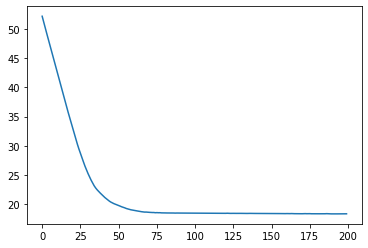

In [21]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')

In [22]:
print(model.layers)
print(model.layers[0].get_weights())

[<keras.layers.preprocessing.normalization.Normalization object at 0x7fc62fbdce50>, <keras.layers.core.dense.Dense object at 0x7fc628475910>]
[array([1.7423927e+03, 2.8363338e+00, 1.4206999e+02, 1.7433327e-01,
       4.3566662e-01], dtype=float32), array([1.3420280e+06, 2.8067799e+00, 6.6846924e+03, 3.2599976e+01,
       3.0759226e+01], dtype=float32), 300]


## Extracting New Testing Data File

In [23]:
testdf_features.describe()

,car.count,wind.velocity,wind.direction,temperature.1,temperature.30
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1631.320544,3.123000,146.375000,0.715500,1.235500
std,1223.552223,1.713579,93.386022,4.668435,4.592674
min,75.000141,0.500000,2.000000,-13.400000,-13.500000
25%,333.249886,1.700000,75.000000,-3.000000,-1.300000
50%,1557.997860,2.900000,97.500000,1.700000,2.600000
75%,2666.993502,4.300000,220.000000,4.825000,4.800000
max,4089.998981,8.300000,354.000000,7.800000,8.600000


In [24]:
yTest = model.predict(testdf_features)

In [25]:
yTest.shape

(200, 1)

In [26]:
print(yTest)

[[24.775417]
 [43.48512 ]
 [26.552723]
 [67.465126]
 [19.757185]
 [57.903297]
 [37.41369 ]
 [34.270702]
 [48.64232 ]
 [56.439533]
 [47.23084 ]
 [10.780655]
 [20.044094]
 [43.971863]
 [22.829243]
 [48.557457]
 [57.92623 ]
 [42.256287]
 [20.044094]
 [51.054028]
 [78.31734 ]
 [71.27313 ]
 [25.413647]
 [47.772568]
 [38.33532 ]
 [70.95321 ]
 [27.931637]
 [36.645565]
 [43.48512 ]
 [51.054028]
 [22.297808]
 [28.381895]
 [33.303497]
 [38.551434]
 [58.116497]
 [42.65806 ]
 [52.599068]
 [67.465126]
 [21.672419]
 [52.599068]
 [28.50425 ]
 [48.557457]
 [26.552723]
 [52.599068]
 [24.775417]
 [47.772568]
 [53.525227]
 [14.987709]
 [29.557087]
 [28.381895]
 [22.297808]
 [42.256287]
 [83.38678 ]
 [28.381895]
 [45.74471 ]
 [37.41369 ]
 [59.710022]
 [48.64232 ]
 [51.18786 ]
 [60.164997]
 [43.971863]
 [68.42189 ]
 [47.772568]
 [50.27101 ]
 [44.024323]
 [35.343285]
 [48.64232 ]
 [30.425343]
 [36.913765]
 [51.18786 ]
 [67.465126]
 [43.044777]
 [79.661545]
 [79.661545]
 [42.65806 ]
 [44.024323]
 [27.214375]

In [27]:
testdf_features['s02'] = yTest
testdf_features.head()

,car.count,wind.velocity,wind.direction,temperature.1,temperature.30,s02
0,129.999421,3.0,217,2.1,2.7,24.775417
1,2447.004739,5.7,81,-4.6,-4.8,43.485119
2,1185.002307,4.9,229,4.9,4.8,26.552723
3,3636.001981,3.4,186,2.4,2.8,67.465126
4,958.998969,6.9,50,-6.8,-6.9,19.757185


In [28]:
first_column = testdf_features.pop('s02')

In [29]:
# insert column using insert(position,column_name,
# first_column) function
testdf_features.insert(0, 's02', first_column)
testdf_features.head()

,s02,car.count,wind.velocity,wind.direction,temperature.1,temperature.30
0,24.775417,129.999421,3.0,217,2.1,2.7
1,43.485119,2447.004739,5.7,81,-4.6,-4.8
2,26.552723,1185.002307,4.9,229,4.9,4.8
3,67.465126,3636.001981,3.4,186,2.4,2.8
4,19.757185,958.998969,6.9,50,-6.8,-6.9


In [30]:
first_column.to_csv('predicted_TEST.txt', sep=',', index=False)

In [38]:
#Testing Data txt file with predicted data
files.download('predicted_TEST.txt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Making Predictions

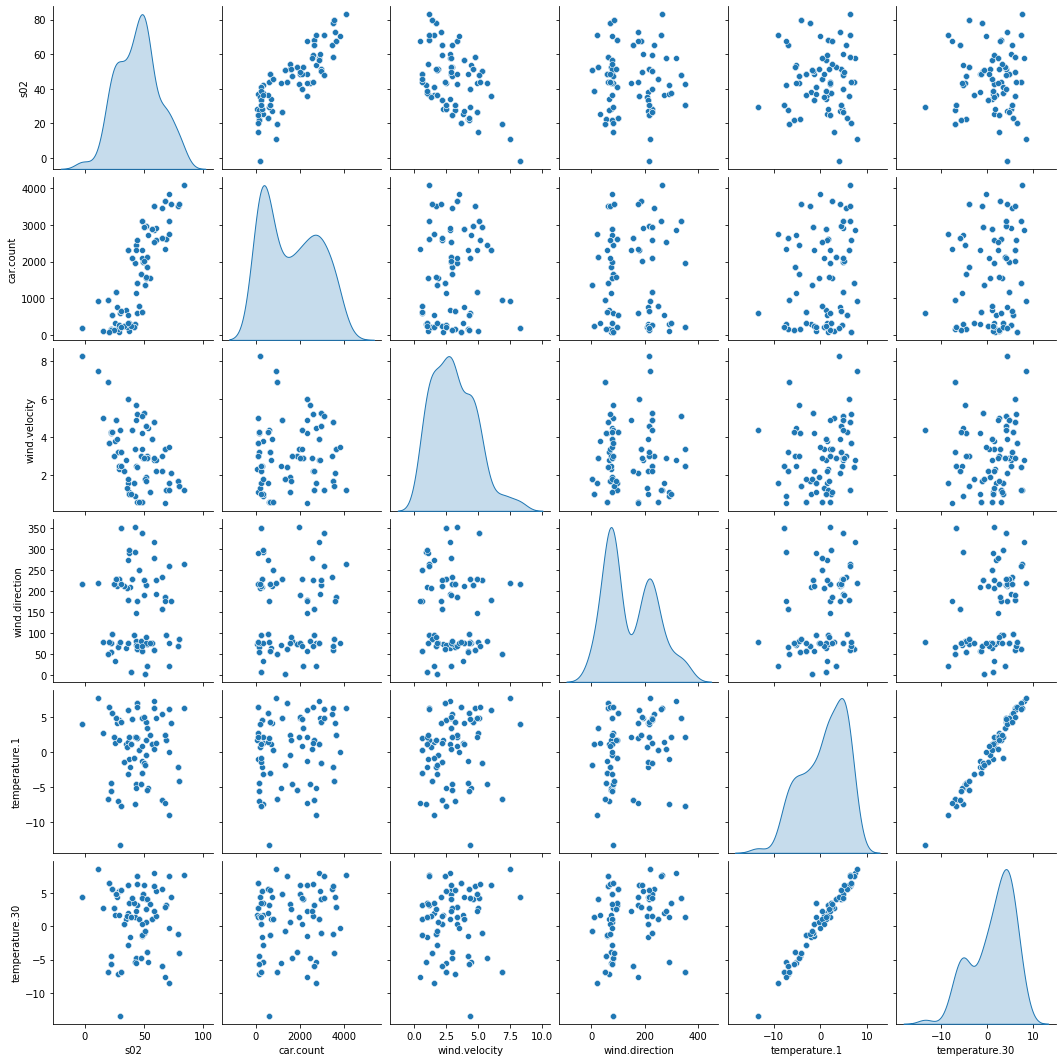

In [32]:
sns.pairplot(testdf_features, diag_kind='kde')

In [33]:
tdf = testdf_features
tdf.head()

,s02,car.count,wind.velocity,wind.direction,temperature.1,temperature.30
0,24.775417,129.999421,3.0,217,2.1,2.7
1,43.485119,2447.004739,5.7,81,-4.6,-4.8
2,26.552723,1185.002307,4.9,229,4.9,4.8
3,67.465126,3636.001981,3.4,186,2.4,2.8
4,19.757185,958.998969,6.9,50,-6.8,-6.9


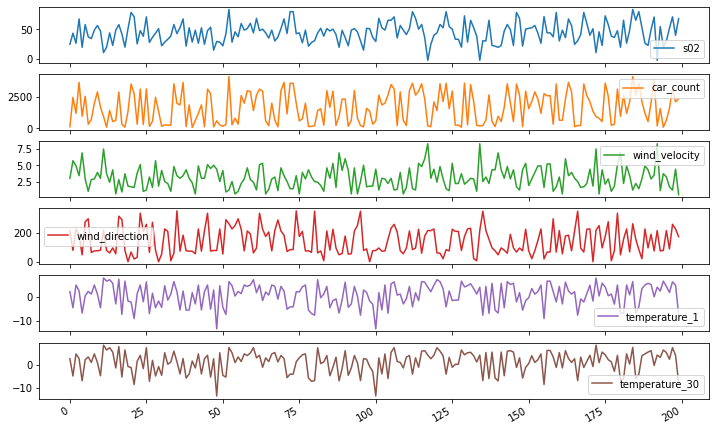

In [49]:
tdf.plot(subplots=True, figsize=(12,8))
plt.show();

In [34]:
#Let's rename these columns
tdf.rename(columns={"car.count": "car_count", "wind.velocity": "wind_velocity", "wind.direction": "wind_direction", "temperature.1": "temperature_1", "temperature.30": "temperature_30"}, inplace=True)
print(tdf.columns)

Index(['s02', 'car_count', 'wind_velocity', 'wind_direction', 'temperature_1',
       'temperature_30'],
      dtype='object')


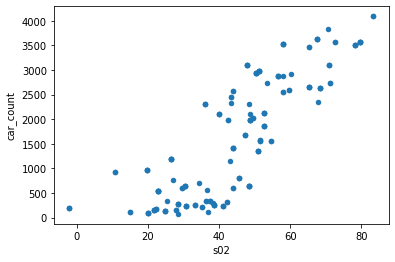

In [35]:
tdf.plot("s02", "car_count", kind='scatter')
plt.show;

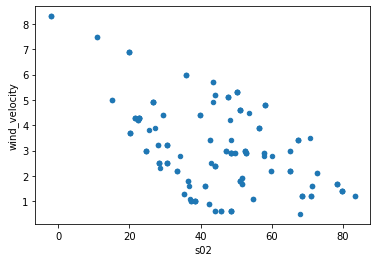

In [36]:
tdf.plot("s02", "wind_velocity", kind='scatter')
plt.show;

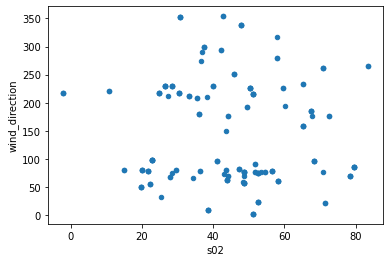

In [39]:
tdf.plot("s02", "wind_direction", kind='scatter')
plt.show;

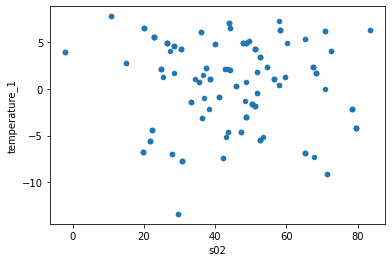

In [40]:
tdf.plot("s02", "temperature_1", kind='scatter')
plt.show;

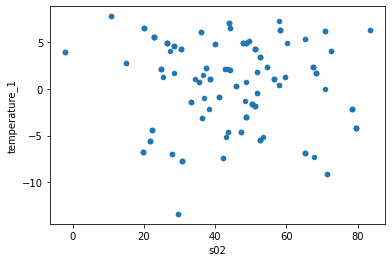

In [41]:
tdf.plot("s02", "temperature_1", kind='scatter')
plt.show;

## R-Squared

In [42]:
X = traindf_features
Y = traindf['so2']
Yhat = model.predict(traindf_features).flatten()

In [43]:
#turn X and Y into numpy arrays
X = np.array(X)
Y = np.array(Y)
Yhat = np.array(Yhat)

In [44]:
#Normalize X via the Normalization layer method
# (input - mean) / sqrt(var)
X2 = (X - X.mean()) / math.sqrt(np.var(X))
X2

array([[ 1.22472601, -0.43788862, -0.30673679, -0.4413798 , -0.43975058],
       [ 2.27090292, -0.43649215, -0.34281227, -0.44568558, -0.44405637],
       [ 2.9179451 , -0.43684127, -0.38819756, -0.42799696, -0.42799696],
       ...,
       [-0.04606074, -0.43439745, -0.20316525, -0.43404833, -0.43369921],
       [-0.04955373, -0.43695764, -0.34746718, -0.44999136, -0.44929313],
       [ 1.93807817, -0.43602666, -0.191528  , -0.44335813, -0.4413798 ]])

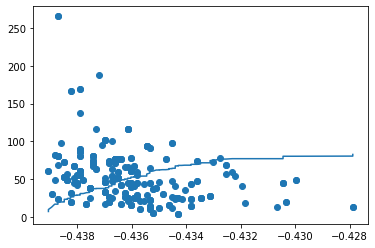

In [45]:
# Sort X and Sort Y and plot the data
plt.scatter(X2[:,1], Y)
plt.plot(sorted(X2[:,1]), sorted(Yhat))
plt.show();

In [46]:
#calculate r-squared
d1 = Y - Yhat
d2 = Y - Y.mean()
r2 = 1 - d1.dot(d1) / d2.dot(d2)
print("R-Squared is", r2)

R-Squared is 0.30102088691400286


## Conclusions

Low R-Squared values can happen for a number of reasons. It could mean the sample size is too large, more indepdendent variables need to be added, lack of signifacant cross-validation, and more. 

A 0.3 is considered on the very low end of the spectrum. The most efficiently improvement is likely feature engineering. Taking our data and transforming it in some way beyond normalization. In fact, most of the time spent on creating this model went into trying different feature transformations before utilizing the normalization layer.

Some suggestions are targeting the car count and taking its square root, or getting the mean of the wind velocity. Overall, it is a not an efficient model, and the data requires more tuning through data transformations.

**Time of Completion**: 2.5 hours